# Le emozioni influenzano le emozioni {#sec-cipresso}

**Prerequisiti**

- Leggere *Affects affect affects: A Markov Chain* di @cipresso2023affects.

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [77]:
import os
import itertools
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import bambi as bmb
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
import warnings

warnings.simplefilter(action="ignore")

In [78]:
seed: int = sum(map(ord, "stan_cipresso2023"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(home_directory, '_repositories', 'psicometria')

## Introduzione

L'obiettivo di questo capitolo è implmentare e commenatare la proposta di @cipresso2023affects relativa all'uso delle catene di Markov per lo studio degli stati affettivi.

## La Modellizzazione degli Stati Affettivi

Negli studi di psicologia, il termine "affetto" è utilizzato per descrivere uno stato globale che comprende una vasta gamma di fenomeni, tra cui emozioni, sentimenti e stati d'animo. Gli stati affettivi, in particolare, si riferiscono allo stato emotivo o umore attuale di un individuo in relazione ai suoi obiettivi adattativi. Un'importante contribuzione alla comprensione degli stati affettivi è stata fornita dal modello circomplesso di @russell1980circumplex, che rappresenta le emozioni su un piano bidimensionale, con "attivazione" (arousal) su un asse e "valenza" (valence) sull'altro. Questo modello permette di caratterizzare ogni emozione in base all'intensità dell'esperienza emotiva e alla sua natura positiva o negativa.

Ad esempio, la tristezza è considerata un'emozione con valenza negativa e bassa attivazione, mentre la gioia è vista come un'emozione con valenza positiva e attivazione medio-alta. Negli ultimi vent'anni, sono stati sviluppati numerosi stimoli per studiare questi stati affettivi in modo dettagliato, utilizzando immagini, video, suoni, narrazioni, situazioni reali, realtà virtuale e musica.

Tuttavia, trattare gli affetti come stati indipendenti può non rappresentare accuratamente la complessità della vita reale, dove gli stati emotivi influenzano quelli successivi. Per esempio, uno studente che si sente stressato all'inizio di un esame può continuare a sentirsi stressato durante le fasi successive, rendendo difficile concentrarsi e rispondere alle domande. In questo contesto, è fondamentale riconoscere come gli stati affettivi siano interconnessi e come uno stato possa influenzare quello successivo.

Questo ha portato alla necessità di utilizzare modelli matematici più complessi, come il modello di Markov, per rappresentare le transizioni tra stati affettivi. Questi modelli permettono di analizzare in modo più realistico le dinamiche degli stati affettivi, prendendo in considerazione la continuità e l'influenza reciproca degli stati emotivi nel tempo.

## Un Processo Stocastico per le Dinamiche degli Stati Affettivi

Una catena di Markov è un processo stocastico utilizzato per modellare le dinamiche degli stati affettivi. In termini semplici, è un modello matematico in cui la probabilità di passare da uno stato a un altro dipende solo dallo stato attuale, e non dalla sequenza di eventi precedenti. Questo significa che il futuro stato del sistema è determinato solo dalla sua situazione presente.

### Matrice di Transizione

Per descrivere matematicamente le transizioni tra stati affettivi, utilizziamo una *matrice di transizione*. Questa matrice rappresenta le probabilità di passaggio da uno stato all'altro. Ad esempio, se abbiamo quattro stati affettivi (rilassato, stressato, impegnato e annoiato), la matrice di transizione mostrerà le probabilità di passare da uno di questi stati a un altro. La somma delle probabilità in ogni riga della matrice deve essere pari a 1, poiché il sistema deve sempre trovarsi in uno degli stati.

La matrice di transizione può essere utilizzata per calcolare la probabilità che il sistema si trovi in un determinato stato dopo un certo numero di passaggi. Ad esempio, se la probabilità di essere nello stato A è 0.6 e la probabilità di passare da A a B è 0.3, la probabilità di essere nello stato B dopo un passaggio sarà 0.18 (0.3 * 0.6).

### Stato Stazionario e Grafici Diretti

Dopo un certo numero di passaggi, la catena di Markov può raggiungere uno stato stazionario, in cui le probabilità di essere in ciascuno stato non cambiano più. Questo stato stazionario può essere utilizzato per capire il comportamento a lungo termine del sistema.

Le transizioni tra stati affettivi possono anche essere rappresentate graficamente tramite un *grafo diretto*, dove ogni stato è un nodo e ogni transizione è un arco diretto. Questo aiuta a visualizzare la struttura della catena di Markov e le relazioni tra gli stati.

### Espansione del Modello: Modelli di Markov Nascosti

Le catene di Markov possono essere estese con i *modelli di Markov nascosti* (Hidden Markov Models, HMM) per includere livelli nascosti, ovvero stati che non possono essere osservati direttamente ma possono essere dedotti dai risultati osservabili. In termini di stati affettivi, questi modelli aiutano a comprendere stati latenti sottostanti che danno origine agli stati affettivi osservati, permettendo di tenere conto delle differenze individuali nell'esperienza e nell'espressione degli stati affettivi, così come della possibilità che questi stati possano essere mal classificati o ambigui.

Questi modelli sono utili per analizzare le dinamiche degli stati affettivi e prevedere comportamenti, offrendo un potente strumento per comprendere fenomeni comportamentali specifici, come quelli osservati in gruppi di individui con particolari condizioni psicologiche.

#### Rappresentazione degli Stati Affettivi

Per modellare gli stati affettivi con una catena di Markov, utilizziamo una matrice di transizione in cui ogni elemento rappresenta la probabilità di passare da uno stato affettivo a un altro. Ad esempio, @cipresso2023affects considerano quattro stati affettivi: *rilassato*, *stressato*, *impegnato* e *annoiato*. Possiamo assegnare a ogni transizione possibile tra questi stati una probabilità, creando così la seguente matrice di transizione:

| Da \ A     | Annoiato | Rilassato | Stressato | Impegnato |
|------------|----------|-----------|-----------|-----------|
| Annoiato   | 0.60     | 0.15      | 0.15      | 0.10      |
| Rilassato  | 0.10     | 0.20      | 0.40      | 0.30      |
| Stressato  | 0.20     | 0.10      | 0.20      | 0.50      |
| Impegnato  | 0.30     | 0.10      | 0.20      | 0.40      |
| Stato iniziale (S0) | 0.10     | 0.20      | 0.40      | 0.30      |

*Vettore dello stato stazionario*: Dopo un certo numero di passi, le probabilità di essere in ciascuno stato non cambiano più, raggiungendo quello che viene chiamato *stato stazionario*. Ad esempio, dopo 10 passi, la probabilità di essere nello stato "annoiato" è 0.361351, nello stato "rilassato" è 0.131186, nello stato "stressato" è 0.20817 e nello stato "impegnato" è 0.299293.

#### Vincoli e Modello Grafico

La matrice di transizione deve rispettare alcuni vincoli: tutte le probabilità devono essere non negative e la somma delle probabilità di transizione da uno stato a tutti gli altri deve essere 1, poiché il sistema deve sempre trovarsi in uno degli stati possibili.

Per rappresentare graficamente gli stati affettivi e le transizioni tra di essi, si può usare un *grafo diretto* in cui ogni stato è un nodo e ogni transizione è rappresentata da un arco diretto. Questo tipo di rappresentazione aiuta a visualizzare la struttura della catena di Markov e le relazioni tra gli stati.

![Relazioni tra quattro stati affettivi ipotizzata da @cipresso2023affects.](../../figures/fig_cipresso_2023.png){ width=65% }

#### Calcolo delle Probabilità nel Tempo

Le catene di Markov sono un metodo matematico utilizzato per prevedere l'evoluzione nel tempo di un sistema che può trovarsi in uno di diversi stati. Consideriamo un esempio con quattro stati affettivi: *rilassato*, *stressato*, *impegnato*, e *annoiato*. Utilizzeremo una catena di Markov per modellare come una persona possa passare da uno stato affettivo all'altro nel tempo.

Immaginiamo che inizialmente la persona si trovi nello stato *rilassato*. Questa situazione può essere rappresentata da un vettore iniziale $x_0$, che indica la probabilità di essere in ciascuno dei quattro stati:

- Rilassato: 100%;
- Stressato: 0%;
- Impegnato: 0%;
- Annoiato: 0%.

Il vettore $x_0$ sarà quindi:

$$
x_0 = [1, 0, 0, 0].
$$

Se invece la probabilità iniziale fosse del 50% di essere rilassato e del 50% di essere impegnato, il vettore diventerebbe:

$$
x_0 = [0.5, 0, 0.5, 0].
$$

Successivamente, definiamo una *matrice di transizione* $P$ che descrive le probabilità di transizione da uno stato all'altro in un singolo intervallo di tempo (ad esempio, un'ora o un giorno). Ogni riga della matrice rappresenta lo stato attuale, mentre ogni colonna rappresenta lo stato futuro.

$$
P = \begin{bmatrix}
0.60 & 0.15 & 0.15 & 0.10 \\
0.10 & 0.20 & 0.40 & 0.30 \\
0.20 & 0.10 & 0.20 & 0.50 \\
0.30 & 0.10 & 0.20 & 0.40
\end{bmatrix}
$$

Le probabilità di transizione per ogni stato sono le seguenti:

- *Annoiato*: il 60% delle volte rimane annoiato, il 15% delle volte passa a rilassato o stressato, e il 10% delle volte diventa impegnato.
- *Rilassato*: il 10% delle volte diventa annoiato, il 20% delle volte rimane rilassato, il 40% delle volte diventa stressato, e il 30% delle volte diventa impegnato.
- *Stressato*: il 20% delle volte diventa annoiato, il 10% delle volte diventa rilassato, il 20% delle volte rimane stressato, e il 50% delle volte diventa impegnato.
- *Impegnato*: il 30% delle volte diventa annoiato, il 10% delle volte diventa rilassato, il 20% delle volte diventa stressato, e il 40% delle volte rimane impegnato.

Riconsideriamo il caso in cui la persona sia inizialmente *rilassata*. Il vettore iniziale $x_0$ sarà quindi:

$$
x_0 = [0, 1, 0, 0].
$$

Questo vettore indica una probabilità del 100% di essere nello stato "rilassato" all'inizio.

Per calcolare le probabilità degli stati dopo un giorno, moltiplichiamo il vettore iniziale $x_0$ per la matrice di transizione $P$:

$$
x_1 = x_0 \cdot P = [0, 1, 0, 0] \cdot \begin{bmatrix}
0.60 & 0.15 & 0.15 & 0.10 \\
0.10 & 0.20 & 0.40 & 0.30 \\
0.20 & 0.10 & 0.20 & 0.50 \\
0.30 & 0.10 & 0.20 & 0.40
\end{bmatrix}
$$

Calcoliamo il prodotto per determinare il nuovo vettore delle probabilità:

$$
x_1 = [0.10, 0.20, 0.40, 0.30].
$$

Dopo un giorno, le probabilità di essere in ciascuno stato sono le seguenti:

- 10% probabilità di essere *annoiato*,
- 20% probabilità di essere *rilassato*,
- 40% probabilità di essere *stressato*,
- 30% probabilità di essere *impegnato*.

Per calcolare le probabilità dopo due giorni, moltiplichiamo il vettore $x_1$ per la matrice $P$:

$$
x_2 = x_1 \cdot P = [0.10, 0.20, 0.40, 0.30] \cdot \begin{bmatrix}
0.60 & 0.15 & 0.15 & 0.10 \\
0.10 & 0.20 & 0.40 & 0.30 \\
0.20 & 0.10 & 0.20 & 0.50 \\
0.30 & 0.10 & 0.20 & 0.40
\end{bmatrix}
$$

Eseguendo questo calcolo, otteniamo:

$$
x_2 = [0.225, 0.105, 0.245, 0.425].
$$

Dopo due giorni, le probabilità di essere in ciascuno stato sono:

- 22.5% probabilità di essere *annoiato*,
- 10.5% probabilità di essere *rilassato*,
- 24.5% probabilità di essere *stressato*,
- 42.5% probabilità di essere *impegnato*.

Ripetendo questo processo, possiamo monitorare come le probabilità evolvono nel tempo, permettendoci di modellare l'evoluzione degli stati affettivi di una persona. Continuando a moltiplicare il vettore stato per la matrice di transizione, possiamo raggiungere uno *stato stazionario*, in cui le probabilità non cambiano più di passo in passo. Questo è utile per prevedere il comportamento a lungo termine di una persona nei diversi stati affettivi.

In conclusione, l'approccio basato sulle catene di Markov offre un metodo rigoroso e flessibile per analizzare sistemi complessi che evolvono nel tempo. Questa tecnica non solo permette di modellare dinamiche probabilistiche, ma fornisce anche una base solida per lo sviluppo di modelli predittivi più sofisticati in vari campi di applicazione.

### Un processo di Markov applicato agli stati affettivi

Utilizzare i modelli di catene di Markov è fondamentale per comprendere le dinamiche degli stati affettivi. Questi modelli catturano accuratamente le probabilità di transizione tra stati affettivi, fornendo uno strumento potente per analizzare le dinamiche sottostanti. Studiando tali modelli, i ricercatori possono ottenere informazioni preziose su come le nostre emozioni e reazioni possono cambiare nel tempo.

Ad esempio, un modello di catena di Markov potrebbe rivelare che un'emozione positiva ha maggiori probabilità di passare a uno stato neutro piuttosto che a uno negativo. Un ricercatore potrebbe scoprire che la felicità tende a trasformarsi più facilmente in un sentimento di soddisfazione piuttosto che di tristezza. Per esempio, la probabilità di passare dalla gioia alla soddisfazione potrebbe essere 0.72, mentre quella di passare dalla gioia alla tristezza potrebbe essere 0.28.

## Implementazione

Nelle sezioni seguenti, ci proponiamo di simulare un set di dati basato sul meccanismo generativo dei dati descritto da @cipresso2023affects, utilizzando la matrice di transizione illustrata in precedenza. Successivamente, implementeremo questo meccanismo in Stan per generare i dati simulati e utilizzeremo tali dati per effettuare inferenze sulla matrice di transizione utilizzata nella loro generazione.

Inoltre, svilupperemo in Stan un secondo modello che assume che gli stati affettivi siano indipendenti tra loro, ovvero che non si influenzino reciprocamente. Adatteremo questo secondo modello ai dati simulati e, attraverso l'utilizzo delle tecniche di validazione incrociata LOO, cercheremo di determinare quale modello descrive meglio i dati.

### Simulazione dei Dati

Simuliamo i dati in base al modello generativo ipotizzato da @cipresso2023affects. Per gli scopi presenti, non è necessario capire nei dettagli come questo viene ottenuto.

In [80]:
# Define the states
states = ["Bored", "Relaxed", "Stressed", "Engaged"]

# Define the transition matrix
transition_matrix = np.array(
    [
        [0.60, 0.15, 0.15, 0.10],  # Bored
        [0.10, 0.20, 0.40, 0.30],  # Relaxed
        [0.20, 0.10, 0.20, 0.50],  # Stressed
        [0.30, 0.10, 0.20, 0.40],  # Engaged
    ]
)


# Function to generate the next state
def next_state(current_state):
    return np.random.choice(states, p=transition_matrix[current_state])


# Function to simulate a sequence of states
def simulate_markov_chain(start_state, num_steps):
    current_state = states.index(start_state)
    state_sequence = [start_state]

    for _ in range(num_steps - 1):
        current_state = states.index(next_state(current_state))
        state_sequence.append(states[current_state])

    return state_sequence


# Simulate data
start_state = "Bored"
num_steps = 2000  # Number of steps to simulate
simulated_data = simulate_markov_chain(start_state, num_steps)

Sistemiamo i dati in un dizionario come richiesto da Stan.

In [81]:
# Convert states to numerical indices for Stan
state_to_index = {"Bored": 1, "Relaxed": 2, "Stressed": 3, "Engaged": 4}
stan_data_markov = {
    "N": len(simulated_data),
    "states": [state_to_index[state] for state in simulated_data],
}

In [82]:
print(stan_data_markov["states"][0:20])

[1, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 3, 4, 4, 4, 4, 1, 2, 3, 1]


Per qualche ragione, il posterior predictive check per il modello di Markov porta alla perdita di un'osservazione, mentre il modello che assume l'indipendenza no. Dato che il confronto tra i due modelli mediante ArviZ deve essere basato sullo stesso numero di dati, per semplicità sottraggo un dato dal campione analizzato dal modello che assume l'indipendenza.

In [83]:
stan_data_independence = {
    "N": len(simulated_data) - 1,
    "states": [state_to_index[state] for state in simulated_data[:-1]],
}

print(stan_data_independence["states"][0:20])

[1, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 3, 4, 4, 4, 4, 1, 2, 3, 1]


### Modello Markov

Implementiamo ora in Stan il modello ipotizzato da @cipresso2023affects.

In [84]:
stan_file = os.path.join(
    project_directory, "stan", "cipresso_model.stan"
)

model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N; // number of transitions
  array[N] int states; // sequence of observed states
}
parameters {
  array[4] simplex[4] trans_matrix; // 4x4 transition matrix with simplex constraints
}
model {
  // Prior distribution for the transition matrix (Dirichlet prior)
  for (i in 1 : 4) 
    trans_matrix[i] ~ dirichlet(rep_vector(1.0, 4));
  
  // Likelihood of the observed data
  for (n in 1 : (N - 1)) 
    states[n + 1] ~ categorical(trans_matrix[states[n]]);
}
generated quantities {
  array[N - 1] real log_lik; // array per la log likelihood
  array[N] int<lower=1, upper=4> y_rep; // dati simulati per posterior predictive checks
  
  // Calcolo della log likelihood per ogni osservazione
  for (n in 1 : (N - 1)) {
    log_lik[n] = categorical_lpmf(states[n + 1] | trans_matrix[states[n]]);
  }
  
  // Generazione di dati simulati per posterior predictive checks
  y_rep[1] = states[1]; // il primo stato simulato è lo stesso dello stato osservato
  for (n in 1 : (N - 1)) {

In questo modello incontriamo due concetti nuovi. Il primo concetto è quello di simplex.  

In Stan, il comando `array[4] simplex[4] trans_matrix;` definisce una matrice di transizione 4x4 per un modello di catena di Markov. 

Un *simplex* in Stan è un vettore di numeri positivi che sommano a 1. Nel contesto di una catena di Markov, un *simplex* rappresenta le probabilità di transizione da uno stato ad altri stati, garantendo che la somma delle probabilità di transizione da un particolare stato sia sempre uguale a 1. 

Per esempio, se consideriamo un vettore simplex di dimensione 4, `[p1, p2, p3, p4]`, allora dobbiamo avere:

$$
p1 + p2 + p3 + p4 = 1
$$

e $p_i \geq 0$ per ogni $i$.

La dichiarazione `array[4] simplex[4]` in Stan crea un *array di 4 vettori simplex*, ciascuno di dimensione 4. Questo array rappresenta la matrice di transizione per una catena di Markov con 4 stati. 

Nel codice, `trans_matrix` è la matrice di transizione. L'array `trans_matrix` può essere visto come una matrice 4x4 in cui:

- ogni riga rappresenta uno stato corrente nella catena di Markov;
- ogni colonna rappresenta uno stato successivo possibile;
- gli elementi della matrice rappresentano le probabilità di transizione da uno stato corrente (indicato dalla riga) a uno stato successivo (indicato dalla colonna).

Poiché ogni riga di `trans_matrix` è un simplex, la somma delle probabilità di ogni riga sarà sempre pari a 1, il che è coerente con le proprietà di una matrice di transizione di Markov. 

Consideriamo un esempio per capire meglio:

$$
\text{trans\_matrix} = \begin{bmatrix}
0.60 & 0.15 & 0.15 & 0.10 \\
0.10 & 0.20 & 0.40 & 0.30 \\
0.20 & 0.10 & 0.20 & 0.50 \\
0.30 & 0.10 & 0.20 & 0.40
\end{bmatrix}
$$

In questo esempio:

- La prima riga `[0.60, 0.15, 0.15, 0.10]` rappresenta le probabilità di transizione dallo stato 1 a ciascuno dei quattro stati. La somma è 1.
- La seconda riga `[0.10, 0.20, 0.40, 0.30]` rappresenta le probabilità di transizione dallo stato 2 a ciascuno degli stati, e così via.

Usiamo `simplex[4]` per garantire che le probabilità di transizione da uno stato a tutti gli altri stati sommino a 1. Questa è una proprietà fondamentale di una catena di Markov e assicura che il sistema rimanga all'interno degli stati definiti, senza probabilità negative o somme maggiori di 1.

In conclusione, l'uso di `array[4] simplex[4]` in Stan per definire `trans_matrix` è un modo per rappresentare una matrice di transizione di una catena di Markov. Ogni riga della matrice è un vettore simplex che rappresenta le probabilità di transizione da un dato stato a tutti gli altri stati, rispettando le proprietà di base delle probabilità in un sistema discreto di stati.

Il secondo concetto nuovo che viene usato qui è la distribuzione di Dirichlet. In Stan, l'espressione `trans_matrix[i] ~ dirichlet(rep_vector(1.0, 4));` rappresenta una dichiarazione di prior per la riga `i` della matrice di transizione `trans_matrix` in un modello di catena di Markov. Per capire questa dichiarazione, vediamo cosa significa ogni parte.

La *distribuzione di Dirichlet* è una distribuzione di probabilità continua definita su un simplex. In altre parole, è una distribuzione utilizzata per modellare probabilità che devono sommare a 1, come le righe della matrice di transizione di una catena di Markov.

- *Simplex*: Un simplex di dimensione $K$ è un vettore di $K$ elementi, ognuno dei quali è maggiore o uguale a 0, e la somma di tutti questi elementi è 1. La distribuzione di Dirichlet è una distribuzione su questi vettori simplex.
- *Dirichlet Prior*: Un prior di Dirichlet è spesso utilizzato quando si desidera specificare una distribuzione di probabilità su vettori di probabilità. È particolarmente utile nei modelli bayesiani quando si lavora con probabilità che devono sommare a 1 (come le righe di una matrice di transizione).

Nel contesto di una catena di Markov, ogni riga della matrice di transizione `trans_matrix` rappresenta un vettore di probabilità per le transizioni da uno stato specifico agli altri stati. Queste probabilità devono sommare a 1, il che rende la distribuzione di Dirichlet un'ottima scelta per modellare queste probabilità.

Nell'Espressione `trans_matrix[i] ~ dirichlet(rep_vector(1.0, 4));`

- `trans_matrix[i]`: Questa è la riga `i`-esima della matrice di transizione. Poiché `trans_matrix` è dichiarata come `array[4] simplex[4]`, `trans_matrix[i]` è un vettore simplex di dimensione 4, il che significa che è un vettore di quattro probabilità che sommano a 1.
  
- `dirichlet(rep_vector(1.0, 4))`: Questa è una distribuzione di Dirichlet con parametri pari a `rep_vector(1.0, 4)`, che è un vettore di 4 elementi tutti uguali a 1.

  - `rep_vector(1.0, 4)`: Questa funzione crea un vettore di dimensione 4 con tutti gli elementi uguali a 1.
  - `dirichlet(...)`: La distribuzione di Dirichlet prende questo vettore come parametro, il che significa che assegna una probabilità uguale a tutte le possibili configurazioni delle probabilità, a patto che sommino a 1. Questo tipo di Dirichlet con parametri uguali a 1 è noto come *Dirichlet uniforme*, che rappresenta un prior non informativo. Non assume preferenze particolari per alcuna configurazione delle probabilità.

In pratica, l'istruzione `trans_matrix[i] ~ dirichlet(rep_vector(1.0, 4));` assegna una prior uniforme a ogni riga `i` della matrice di transizione `trans_matrix`. In altre parole, prima di osservare qualsiasi dato, assumiamo che tutte le possibili configurazioni di probabilità di transizione siano ugualmente probabili. Questa è una scelta comune quando non si ha una conoscenza a priori su quali transizioni siano più probabili.

Questo prior permette alla stima della matrice di transizione di essere guidata interamente dai dati osservati, senza imporre vincoli iniziali. In un contesto bayesiano, l'uso di un prior di Dirichlet uniforme consente di aggiornare le stime della matrice di transizione in base ai dati, mantenendo un punto di partenza neutrale.

In conclusione, l'uso della distribuzione di Dirichlet con `rep_vector(1.0, 4)` come prior per ogni riga della matrice di transizione in un modello di catena di Markov è un modo di modellare le probabilità di transizione che sono inizialmente considerate ugualmente probabili, consentendo al modello di apprendere le probabilità specifiche dai dati osservati senza pregiudizi forti. 

Eseguiamo il campionamento utilizzando in input i dati simulati in precedenza.

In [85]:
fit = model.sample(
    data=stan_data_markov,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

Convertiamo l'oggetto `fit_sample` in un formato compatibile con ArviZ.

In [86]:
fit_az = az.from_cmdstanpy(posterior=fit)

Esaminiamo le distribuzioni a posteriori dei paraemtri.

In [87]:
az.summary(fit_az,var_names="trans_matrix", round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"trans_matrix[0, 0]",0.60,0.02,0.57,0.64,0.0,0.0,17525.12,6012.02,1.0
"trans_matrix[0, 1]",0.16,0.01,0.13,0.18,0.0,0.0,17361.50,6448.52,1.0
"trans_matrix[0, 2]",0.14,0.01,0.11,0.16,0.0,0.0,15645.66,6427.68,1.0
"trans_matrix[0, 3]",0.10,0.01,0.08,0.12,0.0,0.0,17950.00,5836.37,1.0
"trans_matrix[1, 0]",0.09,0.02,0.06,0.12,0.0,0.0,15644.09,6035.12,1.0
"trans_matrix[1, 1]",0.22,0.02,0.18,0.27,0.0,0.0,17114.35,6048.90,1.0
"trans_matrix[1, 2]",0.39,0.03,0.33,0.44,0.0,0.0,18574.00,5861.02,1.0
"trans_matrix[1, 3]",0.30,0.03,0.25,0.35,0.0,0.0,16896.79,5880.78,1.0
"trans_matrix[2, 0]",0.20,0.02,0.16,0.24,0.0,0.0,14592.28,6281.19,1.0
"trans_matrix[2, 1]",0.11,0.02,0.08,0.14,0.0,0.0,15605.08,5885.06,1.0


Notiamo come il modello sia stato in grado di recuperare in modo accurato i valori della matrice di transizione utilizzata per simulare i dati.

## Modello Indipendenza

Consideriamo ora un modello di base che presuppone l'indipendenza tra gli stati affettivi. Se questo modello si adatta ai dati altrettanto bene del modello che considera le influenze reciproche tra stati affettivi, secondo il principio del rasoio di Occam, non sarebbe necessario ipotizzare tali influenze tra gli stati.

In [52]:
stan_ind_file = os.path.join(project_directory, "stan", "cipresso_ind_model.stan")

model_ind = CmdStanModel(stan_file=stan_ind_file)
print(model_ind.code())

data {
  int<lower=1> N; // numero di osservazioni
  array[N] int<lower=1, upper=4> states; // sequenza degli stati osservati
}
parameters {
  simplex[4] state_probs; // vettore delle probabilità di ciascuno stato
}
model {
  // Distribuzione a priori uniforme per le probabilità degli stati (Dirichlet(1))
  state_probs ~ dirichlet(rep_vector(1.0, 4));
  
  // Verosimiglianza dei dati osservati trattati come indipendenti
  for (n in 1 : N) 
    states[n] ~ categorical(state_probs);
}
generated quantities {
  array[N] real log_lik; // array per la log likelihood
  array[N] int<lower=1, upper=4> y_rep; // dati simulati per posterior predictive checks
  
  // Calcolo della log likelihood per ogni osservazione
  for (n in 1 : N) {
    log_lik[n] = categorical_lpmf(states[n] | state_probs);
  }
  
  // Generazione di dati simulati per posterior predictive checks
  for (n in 1 : N) {
    y_rep[n] = categorical_rng(state_probs);
  }
}



Per generare il modello di "indipendenza" rispetto al modello "Markov", sono state introdotte diverse modifiche chiave. Vediamo quali sono queste modifiche e come differenziano i due modelli.

Nel modello di Markov, ogni stato successivo dipende dal precedente, con le probabilità di transizione definite da una matrice di transizione. Questo significa che la probabilità di essere in un dato stato al tempo $t+1$ è condizionata dallo stato al tempo $t$.

Nel modello di Indipendenza, gli stati affettivi sono considerati indipendenti tra loro. Ogni osservazione è trattata come un evento separato, senza dipendenza dal precedente. Le probabilità degli stati sono modellate da un vettore di probabilità di stato (`state_probs`), e non da una matrice di transizione.

Il modello di Markov utilizza una matrice di transizione (`trans_matrix`), dove ogni riga è un vettore simplex che rappresenta le probabilità di transizione da uno stato a tutti gli altri stati possibili.

Il modello di Indipendenza utilizza un singolo vettore simplex di dimensione 4 (`state_probs`), che rappresenta le probabilità di ciascuno stato indipendentemente dagli altri stati. Qui, non c'è una matrice di transizione perché non ci sono dipendenze tra stati consecutivi.

Nel modello di Markov, la verosimiglianza dei dati è calcolata in base alla probabilità di transizione tra stati consecutivi. Ogni stato dipende dallo stato precedente, quindi la verosimiglianza riflette questa dipendenza.

Nel modello di Indipendenza, la verosimiglianza è calcolata assumendo che ogni stato osservato sia indipendente dagli altri. La funzione di verosimiglianza usa una distribuzione categorica per ogni stato, basata sul vettore `state_probs`. Non c'è alcuna relazione tra stati consecutivi.

In sintesi, le principali modifiche per passare dal modello "Markov" al modello "indipendenza" sono:

- non esiste dipendenza tra stati successivi;
- utilizza un vettore di probabilità di stato (`state_probs`) anziché una matrice di transizione;
- tratta ogni osservazione come indipendente, utilizzando una distribuzione categorica basata su `state_probs`.

Eseguiamo il campionamento.

In [62]:
fit_ind = model_ind.sample(
    data=stan_data_independence,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

In [63]:
fit_ind_az = az.from_cmdstanpy(posterior=fit_ind)
az.summary(fit_ind_az, var_names="state_probs", round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
state_probs[0],0.34,0.01,0.32,0.36,0.0,0.0,8456.90,5927.18,1.0
state_probs[1],0.13,0.01,0.12,0.15,0.0,0.0,7911.11,5710.21,1.0
state_probs[2],0.22,0.01,0.21,0.24,0.0,0.0,8078.80,6115.46,1.0
state_probs[3],0.30,0.01,0.28,0.32,0.0,0.0,8308.59,6358.41,1.0


Una volta che il ricercatore ha specificato un modello appropriato e verificato che il modello ottiene la convergenza, può valutare se il modello descrive adeguatamente i dati. Le stime dei parametri sono interpretabili solo nella misura in cui il modello rappresenta accuratamente il fenomeno che si sta indagando. Se il modello approssima male i dati, le informazioni contenute nelle stime dei parametri potrebbero non essere rappresentative del processo che il ricercatore sta cercando di analizzare. In tali casi, potrebbe essere necessario riformulare il modello per migliorare la sua capacità di spiegare le osservazioni empiriche.

In [38]:
# Run diagnostics and print results
diagnostic_info = fit_ind.diagnose()
print(diagnostic_info)

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpprjn35f_/cipresso_ind_model8sljhpd5/cipresso_ind_model-20240825085942_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpprjn35f_/cipresso_ind_model8sljhpd5/cipresso_ind_model-20240825085942_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpprjn35f_/cipresso_ind_model8sljhpd5/cipresso_ind_model-20240825085942_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpprjn35f_/cipresso_ind_model8sljhpd5/cipresso_ind_model-20240825085942_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



## Valutazione e Confronto di Modelli

Eseguiamo il calcolo dei valori k di Pareto e la validazione incrociata Leave-One-Out (LOO-CV) utilizzando ArviZ.

In [70]:
loo_result = az.loo(fit_az)
print(loo_result)

Computed from 8000 posterior samples and 1999 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2406.20    26.49
p_loo       12.10        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1999  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [71]:
loo_ind_result = az.loo(fit_ind_az)
print(loo_ind_result)

Computed from 8000 posterior samples and 1999 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2661.47    14.10
p_loo        3.01        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1999  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [73]:
df_comp_loo = az.compare({
    "markov_model": loo_result, 
    "independence_model": loo_ind_result
})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
markov_model,0,-2406.195318,12.103452,0.000000,0.799907,26.494244,0.000000,False,log
independence_model,1,-2661.468120,3.011688,255.272802,0.200093,14.098377,29.877077,False,log


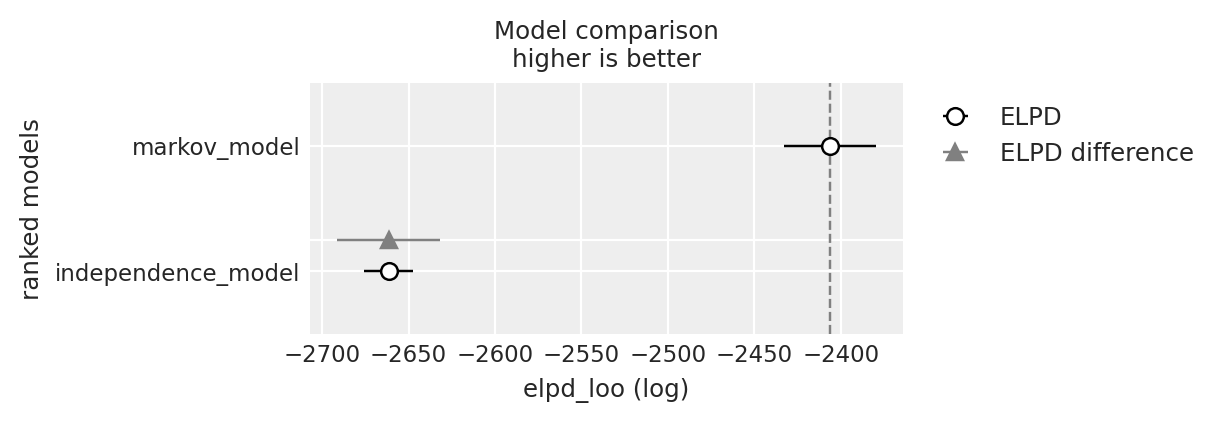

In [74]:
_ = az.plot_compare(df_comp_loo, insample_dev=False)

Il risultato ottenuto mostra chiaramente che la tecnica di validazione incrociata LOO permette di concludere che il modello "Markov" rappresenta i dati in modo molto più accurato rispetto al modello che presuppone l'indipendenza tra gli stati affettivi. Questo è prevedibile, dato che i dati sono stati generati in base alla verosimiglianza implementata nel modello "Markov". Tuttavia, questa dimostrazione evidenzia come, utilizzando metodi bayesiani, sia possibile recuperare facilmente la matrice di transizione tra stati, a condizione che i dati siano stati generati da un processo coerente con il modello implementato in Stan.

Studi di simulazione possono essere condotti per determinare quale dimensione del campione sia necessaria per consentire un recupero accurato dei valori della matrice di transizione. Inoltre, il modello può essere ulteriormente sviluppato per distinguere tra diversi gruppi (ad esempio, pazienti e controlli) o per stimare le caratteristiche individuali dei partecipanti utilizzando un modello gerarchico.

## Riflessioni Conclusive

Secondo @cipresso2023affects, le catene di Markov offrono diversi vantaggi rispetto ai metodi tradizionali per modellare le dinamiche temporali e le interdipendenze degli stati emotivi. 

1. Le catene di Markov sono una strategia di modellazione adattabile che può essere utilizzata per simulare diversi sistemi a stati discreti, inclusi gli stati emotivi. Questa flessibilità consente ai ricercatori di modellare solo gli stati emotivi e le loro connessioni rilevanti per il loro specifico studio.

2. Le dinamiche temporali delle emozioni possono essere analizzate in modo semplice e comprensibile utilizzando le catene di Markov. È possibile fare previsioni sugli stati futuri analizzando le probabilità di transizione tra stati diversi.

3. Le catene di Markov permettono ai ricercatori di valutare la stabilità degli stati emotivi nel tempo, stimando le probabilità di passaggio da uno stato all'altro sia a breve che a lungo termine.

4. Le catene di Markov possono essere facilmente create utilizzando software statistici convenzionali, offrendo un ulteriore vantaggio rispetto ad altri metodi.

Oltre a questi vantaggi pratici, c'è un aspetto interessante nell'usare le catene di Markov per rappresentare gli stati affettivi: richiedono un approccio innovativo nel considerare le transizioni tra stati emotivi. I ricercatori devono rivedere le loro ipotesi preliminari sugli affetti e considerare le transizioni in modo diverso, cercando nuovi tipi di disegni sperimentali. 

Ad esempio, sarebbe utile evocare stati affettivi in base alla valenza e all'attivazione, mantenendo i partecipanti in uno stato per un tempo sufficiente a evocare esclusivamente lo stato desiderato. Successivamente, si dovrebbe passare a un altro stato, mantenendo anche questo per un periodo simile per evocare realmente i nuovi stati nei partecipanti. 

Una delle sfide principali è definire una misura della probabilità di transizione da uno stato all'altro. Questa potrebbe essere una funzione del tempo di latenza necessario per raggiungere un nuovo stato affettivo una volta presentati nuovi stimoli o una misura psicologica o fisiologica durante le transizioni. Attualmente, non esiste una risposta univoca a questo problema, il che rappresenta un invito all'azione per i ricercatori nel raccogliere nuovi dati per comprendere meglio le dinamiche degli stati affettivi utilizzando vari stimoli (foto, video, suoni, ecc.) e strumenti.

@cipresso2023affects propongono che i modelli di catene di Markov possono essere utilizzati per capire come diversi gruppi di individui (ad esempio, pazienti vs. controlli) mostrino diverse matrici di transizione, evidenziando fenotipi comportamentali specifici e una comprensione approfondita dell'evoluzione della salute mentale basata sulle dinamiche degli affetti.

Analizzando questi modelli, potrebbe essere possibile capire come certi disturbi mentali progrediscono e come gli individui esprimono diversi schemi comportamentali basati sui loro stati affettivi. Comprendendo gli affetti nei vari stati, possiamo determinare con maggiore precisione le possibili cause dei disturbi mentali e sviluppare piani di trattamento più efficaci. Ad esempio, i dati possono essere utilizzati per identificare quali emozioni sono più comunemente associate alla depressione, permettendo di focalizzare quelle emozioni come parte del piano di trattamento di un paziente.

Inoltre, i dati possono aiutare a capire quali tipi di interventi e terapie producono i migliori risultati per le persone con malattie mentali, consentendo lo sviluppo di approcci basati sull'evidenza per gestire meglio le condizioni di salute mentale.

In conclusione, secondo @cipresso2023affects, lo studio delle catene di Markov applicato alle dinamiche degli affetti può fornire nuove intuizioni sui comportamenti fenotipici legati agli stati emotivi attraverso le proprietà matematiche dei dati raccolti in disegni sperimentali. Questo permette di evidenziare le transizioni di stato e calcolare le probabilità correlate. Le limitazioni future riguardano il modo in cui le probabilità vengono stimate e la possibile struttura delle catene di Markov, soprattutto quando lo stato del sistema non è direttamente osservabile ma può essere dedotto da una sequenza di osservazioni. In questi casi, possono essere considerati i modelli di Markov nascosti, che estendono ulteriormente il modello di transizione. Più in generale, il potenziale di questi processi matematici potrebbe chiarire le dinamiche affettive e la misura in cui queste dinamiche spiegano i processi di salute mentale a un livello più alto, portando a una migliore comprensione e interventi.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [76]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Sun Aug 25 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

bambi     : 0.14.0
logging   : 0.5.1.2
numpy     : 1.26.4
pandas    : 2.2.2
arviz     : 0.18.0
scipy     : 1.14.0
cmdstanpy : 1.2.4
matplotlib: 3.9.1

Watermark: 2.4.3

